# NLP кейс от Т-банка

-----
----
## Описание задания
-------
-----

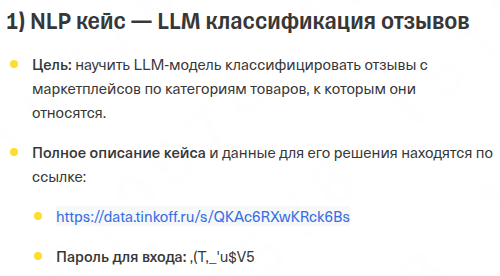

# LLM классификация отзывов

## Цель кейса

Научить LLM-модель классифицировать отзывы с маркетплейсов по категориям товаров, к которым они относятся.

## Критерий успешности:

* Модель должна как можно лучше классифицировать тестовые отзывы по заданным категориям
* Время классификации одного примера не должно превышать `5` секунд
* Оценка качества производится по метрике `Weighted F1`, включая класс "нет товара"

## Данные и пререквизиты

* https://data.tinkoff.ru/s/QKAc6RXwKRck6Bs пароль `,(T,_'u$V5`
* train и test датасеты — неразмеченные тексты отзывов
* Список категорий товаров, на которые необходимо классифицировать отзывы

## Ограничения

* Запрещено использовать **внешние API** (например, ChatGPT, DeepSeek и т.д.) для решения задачи или разметки данных.
* Запрещено использовать тестовую выборку для обучения или валидации, кроме как для финальной оценки.
* Запрещено использовать **внешние данные** для обучения, но разрешена аугментация и генерация синтетических данных на основе выданных.
* Решение должно **умещаться в ресурсы Google Colab** (16GB VRAM T4).
* Время классификации одного примера — **не более** `5` секунд в среднем.

## Ожидаемый формат решения

### Что нужно сдать:

* `Jupyter Notebook` или публичный репозиторий на `GitHub` со всеми этапами решения
* `CSV`-файл с предсказанными категориями для тестовой выборки

### Обязательные элементы решения:

* Пайплайн разметки данных и подготовки их для обучения LLM
* Обучение модели и оценка её качества
* Разметка тестового набора с замером скорости работы
* `README.md` с описанием ключевых этапов решения задачи

## Критерии оценивания

### Основные критерии:

* В первую очередь: сложность и глубина решения — автоматическая разметка, дообучение модели (например, LoRA, FT, PEFT), использование продвинутых методов промпт-инжиниринга
* Качество модели — оценивается по метрике `Weighted F1` по всем категориям, включая "нет товара"

## Подсказки и FAQ

### Чего не стоит делать:

* Ручная разметка данных — не рекомендуется, даже если она дает хорошие результаты
* Слишком простая разметка (например, через регулярные выражения)
* Сведение задачи к простому подбору промпта без дообучения модели

### Рекомендации:

* Используйте другую открытую LLM для автоматической разметки данных
* Рассмотрите различные методы дообучения: LoRA, PEFT, полное fine-tuning
* Экспериментируйте с промптами и инференсом для улучшения качества
* Убедитесь, что модель соответствует ограничениям по скорости и ресурсам

-----
----
## Описание модулей
* __transformers__ - библиотека от HF, предоставляющая тысячи предобученных моделей для различных задач и иструменты для их использования и тонкой настройки
* __accelerate__ - библиотека от HF, разработанная для упрощения обучения и запуска больших моделей на различных аппаратных конфигурациях (несколько GPU - минимальные изменения в коде)
* __bitsandbytes__ - библиотека предоставляет высокооптимизированные CUDA-функции для операций с тензорами, особенно для квантованных данных (например, 8-битные или 4-битные числа). Она критически важна для загрузки больших моделей в 4-битном формате, что позволяет запускать их на GPU с меньшим объемом памяти.
* __peft__ - библиотека также от HF, которая реализует методы эффективной тонкой настройки больших моделей. Вместо того чтобы обновлять миллиарды параметров PEFT позволяет тонко настраивать лишь небольшое подмножество параметров(условно настраивать только классификационную голову), что приводит к экономии вычислительных ресурсов и памяти.

In [3]:
!pip install -U -q transformers
!pip install -U -q accelerate
!pip install -U -q bitsandbytes

!pip install -U -q peft
!pip install -q tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 17.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


-----
-----
## Загрузка данных

In [5]:
#Подключаем диск - монтируем его в коллаб
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sirius_T_bank/train.csv')
df['text'][0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'Заказали 14.10.2017 , получили 25.10.2017 \r\nНа мой размер 42, широкий как мешок. Надо было все таки размер  S заказать. \r\nПо поводу качества хороший пуховик. \r\nМех натуральный , съемный. \r\nБуду продавать .'

In [ ]:
categories = [
    'бытовая техника',
    'обувь',
    'одежда',
    'посуда',
    'текстиль',
    'товары для детей',
    'украшения и аксессуары',
    'электроника',
    'нет товара'
]

In [ ]:
# Assuming X_train is a pandas DataFrame and mask_neq is a boolean Series
# First, filter X_train using the mask
filtered_X_train = X_train[mask_neq]

# Iterate through the rows of the filtered DataFrame
for index, row in filtered_X_train.iterrows():
    # Access columns by name using dot notation or dictionary-style access
    print(f'Отзыв: {row["text"]}  |  Метка: {row["pred"]}')

NameError: name 'X_train' is not defined

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
df = pd.read_csv('X_train_all.csv')
df['text'][43]

'Размер не соответствует. Заказали 4XL по факту оказался на 50 размер максимум.'

In [ ]:
import pandas as pd

# Replace '/path/to/your/dataset.csv' with the actual path to your dataset file
local_df = pd.read_csv('train.csv')
display(local_df.head())

-----
----
### Чистка данных
Удаляем отзывы, которые написаны на английском - т.к по заданию нужно будет классифицировать толоко русские отзывы



In [8]:
# pd.set_option('display.max_rows', None)
# rows_to_drop = [1616, 1503, 1459, 1408, 815, 691, 531, 276]
# df = df.drop(rows_to_drop).reset_index(drop=True)
# display(df)

Removed rows with English reviews as per the task requirements.

-----
----
## Пайплайн разметки данных и подготовки их для обучения LLM

Выбор предварительно обученной модели пал на   __IlyaGusev/saiga_mistral_7b__ - открытая instruct-модель, дообученная на огромном  корпусе русскоязычных текстов. Она идеально вписывалась в задачу после квантизации до 4х-битной версии, поэтому я решил начать именно с нее.
* __istruct-модель__. Такие модели обучались на большом множестве задач(__инструкция - ответ__) из-за чего способны лучше понимать указания пользователя, правильнее выполнять его требования и рекомендации а для промпт-инжиниринга,которым я и буду заниматься при решении данной задачи, это особенно важно.
* __7b-модели__  занимают примерно __14 ГБ__ -> оставшейся памяти явно не хватит для дальнейшей работы, поэтому беру __4-bit__ версию(nf4 очень хорошо сохраняет производительность модели, поэтому потеря качества будет незаметной). Как показывает практика, лучше использовать большую дисциллированную или квантизированную предобученную модель, чем маленькую, но в оригинальном виде.

PS: результаты разметки с использованием промпт инжиниринга показали плачевные результаты, модель плохо понимала русские слова (носки относила к категории обуви, шерстяную одежду, которая электризуется - к электронике, а ветровку - к бытовой техники), поэтому позже было принято решение перейти на __Qwen2.5-7B-Instruct__, потому что в отличие от saiga_mistral она изначально обучалась на многоязычном корпусе текстов с преобладание русского языка, поэтому она будет иметь более глубокие семантические связи русских слов, т.е  обладать более богатыми внутренними представлениями слов, чем __IlyaGusev/saiga_mistral_7b__, которую всего лишь дообучили под русский текст.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "IlyaGusev/saiga_mistral_7b"

#Задаем конфиг для 4-битной квантизации
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

In [ ]:
def build_prompt(review_text: str) -> str:
    prompt = (
        "Мне нужно чтобы ты побыл сейчас в роли классификатора.\n"
        "Определи по отзыву о товаре, категорию к которой он относится.\n"
        f"Есть несколько категорий: {', '.join(categories)}.\n"
        "ПРАВИЛО: Если в отзыве говорится только о доставке, упаковке, сроках или просто выражаются эмоции без упоминания товара, выбери категорию 'нет товара'.\n"
        "Чтобы тебе было понятнее, что я от тебя требую, вот следующие примеры:\n\n"

        "--- КАТЕГОРИЯ: нет товара ---\n"
        "Как определять: Выбирай эту категорию, если отзыв говорит ТОЛЬКО о доставке, сроках, упаковке, эмоциях или общих фразах без упоминания самого товара.\n\n"
        "--- Пример 1 ---\n"
        "ОТЗЫВ: \"Все отлично!!!\"\n"
        "КАТЕГОРИЯ: нет товара\n\n"
        "--- Пример 2 ---\n"
        "ОТЗЫВ: \"Заказали 14.10.2017, получили 25.10.2017\"\n"
        "КАТЕГОРИЯ: нет товара\n\n"

        "--- КАТЕГОРИЯ: одежда ---\n"
        "Как определять: Выбирай эту категорию, если в отзыве описывается посадка на теле («велико», «мало», «по размеру», «на рост...», «в груди», «в талии»), материал («синтетика», «хлопок», «тонкая ткань»), фасон («топ», «платье», «кофта», «штаны») — даже если название товара не указано прямо.\n\n"
        "--- Пример 3 ---\n"
        "ОТЗЫВ: \"очень крутой топ, заказала 11.11 пришел 28.11\"\n"
        "КАТЕГОРИЯ: одежда\n\n"
        "--- Пример 4 ---\n"
        "ОТЗЫВ: \"Но рост 180 по колено, качество хорошее, доставка быстрая\"\n"
        "КАТЕГОРИЯ: одежда\n\n"

        "--- КАТЕГОРИЯ: обувь ---\n"
        "Как определять: Выбирай эту категорию, если отзыв содержит упоминания о размере обуви («на 39», «маломерит», «велики», «на ногу»), удобстве («пятка болтается», «давит», «удобные»), или конкретных типах обуви («туфли», «кроссовки», «сандалии»).\n\n"
        "--- Пример 5 ---\n"
        "ОТЗЫВ: \"На 39 размер велики, пятка болтается, хоть и симпатичные\"\n"
        "КАТЕГОРИЯ: обувь\n\n"
        "--- Пример 6 ---\n"
        "ОТЗЫВ: \"на размер 35-36 мне как раз. не знаю как их натягивают на 37-38\"\n"
        "КАТЕГОРИЯ: обувь\n\n"

        "--- КАТЕГОРИЯ: бытовая техника ---\n"
        "Как определять: Выбирай эту категорию, если отзыв описывает работу прибора («стиралка шумит», «пылесос не тянет», «греется», «не включается»), его функции («режим», «таймер», «мощность»), или тип техники («холодильник», «чайник», «микроволновка»).\n\n"
        "--- Пример 7 ---\n"
        "ОТЗЫВ: \"Стиралка шумит как самолёт, но бельё вымывает идеально\"\n"
        "КАТЕГОРИЯ: бытовая техника\n\n"
        "--- Пример 8 ---\n"
        "ОТЗЫВ: \"Пылесос слабый, пыль не собирает, только шумит и греется\"\n"
        "КАТЕГОРИЯ: бытовая техника\n\n"

        "--- КАТЕГОРИЯ: посуда ---\n"
        "Как определять: Выбирай эту категорию, если отзыв упоминает сковородки, кастрюли, чашки, тарелки, ножи — и описывает их свойства: «пригорает», «ручка греется», «сколы», «материал», «нагревается».\n\n"
        "--- Пример 9 ---\n"
        "ОТЗЫВ: \"Сковорода не пригорает, но ручка греется — надо перчатки надевать\"\n"
        "КАТЕГОРИЯ: посуда\n\n"
        "--- Пример 10 ---\n"
        "ОТЗЫВ: \"Чашка красивая, но треснула после первого использования в микроволновке\"\n"
        "КАТЕГОРИЯ: посуда\n\n"

        "--- КАТЕГОРИЯ: текстиль ---\n"
        "Как определять: Выбирай эту категорию, если отзыв описывает постельное бельё, полотенца, шторы, покрывала — с упоминанием «сатин», «бязь», «махра», «мягкое», «после стирки село», «набор».\n\n"
        "--- Пример 11 ---\n"
        "ОТЗЫВ: \"Постельное бельё из сатина, мягкое, но после стирки немного село\"\n"
        "КАТЕГОРИЯ: текстиль\n\n"
        "--- Пример 12 ---\n"
        "ОТЗЫВ: \"Полотенца приятные, но после первой стирки полиняли и стали жёсткими\"\n"
        "КАТЕГОРИЯ: текстиль\n\n"

        "--- КАТЕГОРИЯ: товары для детей ---\n"
        "Как определять: Выбирай эту категорию, если в отзыве есть слова «дочке», «сыну», «ребёнку», «детский», «для малыша», «пижама для дочки», «игрушка», «коляска», «стульчик».\n\n"
        "--- Пример 13 ---\n"
        "ОТЗЫВ: \"Пижама для дочки 5 лет — мягкая, с единорогами, она в восторге\"\n"
        "КАТЕГОРИЯ: товары для детей\n\n"
        "--- Пример 14 ---\n"
        "ОТЗЫВ: \"Игрушка сломалась через день, ребёнок расстроился\"\n"
        "КАТЕГОРИЯ: товары для детей\n\n"

        "--- КАТЕГОРИЯ: украшения и аксессуары ---\n"
        "Как определять: Выбирай эту категорию, если отзыв описывает серьги, кольца, браслеты, цепочки, ремни, шарфы, перчатки, сумки — с упоминанием «застёжка», «цепочка», «камень», «дизайн», «носить с...».\n\n"
        "--- Пример 15 ---\n"
        "ОТЗЫВ: \"Серьги с кристаллами — красивые, но застёжка слабая, боюсь потерять\"\n"
        "КАТЕГОРИЯ: украшения и аксессуары\n\n"
        "--- Пример 16 ---\n"
        "ОТЗЫВ: \"Шарф мягкий, но слишком короткий, не завязывается как на фото\"\n"
        "КАТЕГОРИЯ: украшения и аксессуары\n\n"

        "--- КАТЕГОРИЯ: электроника ---\n"
        "Как определять: Выбирай эту категорию, если отзыв описывает гаджеты: «наушники», «телефон», «планшет», «зарядка», «батарея», «Bluetooth», «экран», «громкость», «подключение».\n\n"
        "--- Пример 17 ---\n"
        "ОТЗЫВ: \"Наушники Bluetooth подключились сразу, звук чистый, батарея держится 5 часов\"\n"
        "КАТЕГОРИЯ: электроника\n\n"
        "--- Пример 18 ---\n"
        "ОТЗЫВ: \"Телефон быстро разряжается, экран тусклый, камера мылит\"\n"
        "КАТЕГОРИЯ: электроника\n\n"

        "--- А ТЕПЕРЬ ТВОЯ ЗАДАЧА ---\n"
        "Присылай в качестве ответа только название категории \n"
        "Используя правило и примеры, определи категорию для следующего отзыва.\n\n"
        f"СПИСОК КАТЕГОРИЙ: {', '.join(categories)}\n\n"
        f"ОТЗЫВ: \"{review_text}\"\n\n"
        "КАТЕГОРИЯ:"
    )
    return prompt

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()  # Это нужно сделать один раз для активации интеграции с pandas
import time
def classify_review(review_text, model, tokenizer):
    """Функция для классификации одного отзыва"""
    prompt = build_prompt(review_text)
    #Токенизация промпта
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=5000).to(model.device)
    #Генерация ответа
    outputs = model.generate(
        **inputs,
        max_new_tokens=10,
        pad_token_id=eos_token_id,
        eos_token_id=eos_token_id,
        do_sample=False
    )
    # Получаем длину входного промпта в токенах
    input_length = inputs.input_ids.shape[1]

    # Берём только сгенерированные токены (после промпта)
    generated_tokens = outputs[0][input_length:]

    # Декодируем только их
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    if generated_text in categories:
        return generated_text
    else:
        return None

classify_review("Как же мне нравится это кофемашина, просто класс", model, tokenizer)

def classify_dataframe(df, model, tokenizer):
    """
    Принимает DataFrame, классифицирует отзывы и выводит статистику по времени.
    Возвращает Series с предсказаниями.
    """
    tqdm.pandas(desc="Классификация отзывов")

    start_time = time.time()
    predictions = df['text'].progress_apply(
        lambda review: classify_review(review, model, tokenizer)
    )
    end_time = time.time()
    total_time = end_time - start_time
    num_examples = len(df)
    # Проверяем, что обработан хотя бы один пример, чтобы избежать деления на ноль
    if num_examples > 0:
        avg_time_per_example = total_time / num_examples
    else:
        avg_time_per_example = 0

    print("\n" + "="*40)
    print("Классификация завершена!")
    print(f"Всего обработано примеров: {num_examples}")
    print(f"Общее время выполнения: {total_time:.2f} секунд")
    print(f"СРЕДНЕЕ ВРЕМЯ НА ОДИН ПРИМЕР: {avg_time_per_example:.4f} секунд")
    print("="*40 + "\n")

    return predictions

In [ ]:
predictions = classify_dataframe(df, model, tokenizer)

Классификация отзывов:   0%|          | 0/1818 [00:00<?, ?it/s]


Классификация завершена!
Всего обработано примеров: 1818
Общее время выполнения: 8331.14 секунд
СРЕДНЕЕ ВРЕМЯ НА ОДИН ПРИМЕР: 4.5826 секунд



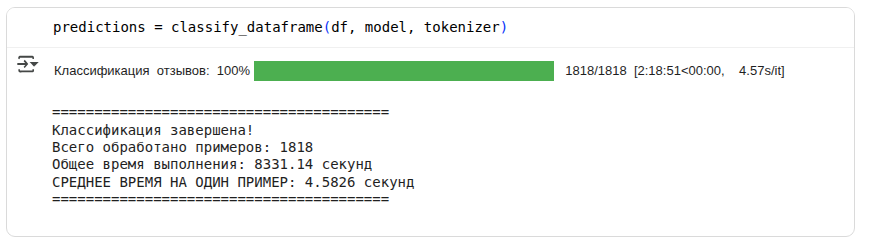

----
----
__CHECKPOINT 1__
Получена разметка с помощью открытой модели __IlyaGusev/saiga_mistral_7b__

In [ ]:
# df.to_csv('/content/drive/My Drive/Colab Notebooks/Sirius_T_bank/saiga_mistral_7b_df_train.csv', index=False)
# predictions.to_csv('/content/drive/My Drive/Colab Notebooks/Sirius_T_bank/saiga_mistral_7b_prediction_train.csv', index=False)

In [ ]:
import pandas as pd
predictions = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sirius_T_bank/saiga_mistral_7b_prediction_train.csv')
df_train_pred = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sirius_T_bank/saiga_mistral_7b_df_train.csv')


------
-----

## Анализ разметки

Просмотрев качество выдаваемое на объектов из миноритарных классов, я понял что с разметкой явно есть проблемы:

| Отзыв                                                                                                                                                   | Предсказанная Категория |
|---------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------|
| Очень очень сильно электризуется ,<br> прилипает к телу                                                                                                 | электроника             |
| трек неотслеживался                                                                                                                                     | электроника             |
| очень хорошая ветровка. качество просто супер.<br> соответственно описанию.                                                                             | бытовая техника         |
| Немного разочарована. Брала размер m на параметры 80-65-90 оказалась впритык,<br> после стирки точно сядет. Чистая синтетика. Электризуется отлично)) | бытовая техника         |
| Быстро Качественно. Я довольна                                                                                                                         | бытовая техника         |
| водолазка хорошая, теплая, для тела очень приятная,<br> мягонькая! очень долгая доставка!                                                                 | бытовая техника         |
| Дырки, нитки , затяжки                                                                                                                                | посуда                  |
| Минус после стирку пошёл весь в катушки                                                                                                                  | посуда                  |
| Рисунок не очень чёткий, а ткань прозрачная,<br> видно нижнее бельё                                                                          | текстиль                |
| Очень тугие резинки на чулках,<br> пришлось стягивать их намного ниже, чем обычно должны носится ,<br> натянула чуть выше колен, чтобы не давило!<br> Мой размер М, чулки наверное рассчитаны на s или даже на xs | обувь                   |

Эту проблему нужно определенно решить.
* Первым делом я внес корректировки в промпт(добавил подсказки, ключевые слова, свойства и правила по которым можно с легкостью классифицировать тот или иной товар, внес для каждой категории помимо обычных примеров, ещё и негативные на которых модель может троить. А ещё (наверно самое важное) - задал четкие критерии выбора категории, которых до этого у меня не было(иногда небольшая формальность может помочь с кашей в голове). __После этих изменений в промпте у меня появились улучшения в качестве разметки. Оценки делал визуальную + писал небольшие коварные примерчики и смотрел что при одном и другом промпте выдается.
* Решил попробовать сменить ещё и выбранную предобученную модель на __Qwen/Qwen2.5-7B-Instruct__, потому что старая плохо понимала русские слова. Такой выбор уже описывал выше(если коротко, то __Qwen/Qwen2.5-7B-Instruct__ изначально предназначалась для русского, который входит в топ 3-5 языков после китайского и английского (__от 60 до 90 миллиардов русских токенов__), в отличие от __IlyaGusev/saiga_mistral_7b__,которая изначально предназначалась для английского и лишь после дообучения стало понимать русский(повидала на порядок меньше - __180 миллионов (180M) русских токенов__)

### Мои четкие критерии выбора категории

*   **нет товара:**
    *   Выбираем эту категорию, если в отзыве нет четкого упоминания конкретного товара или какого описания, которые позволяют однозначно отнести его к одной из других категорий.
    *   Сюда относятся отзывы только о доставке, упаковке, общих эмоциях, или если отзыв слишком общий ("сплошная синтетика") без контекста, позволяющего определить товар.
    *   *Исключение:* Если по косвенным признакам можно с высокой вероятностью сказать, что это про одежду (например, "была мне по колено 3XL слишком большой"), то это "одежда".
    * Можно методом исключений определить что отзыв относится к одной из двух категорий: {__предполагаемая категория__, __нет товара__}

*   **одежда:**
    *   Любая вещь из ткани, которую надевают на тело (платье, брюки, кофта, носки, чулки, белье).
    *   Отзывы, описывающие посадку по фигуре, материал (кроме общих случаев), фасон, или специфические предметы одежды.
    *   *Исключение:* Товары, которые дополняют основной образ, но не являются его основой (шапки, перчатки, шарфы, ремни, сумки, часы) относятся к категории **украшения и аксессуары**.

*   **обувь:**
    *   Все, что надевается на стопу для ходьбы (кроссовки, туфли, сапоги).
    *   Отзывы, описывающие размер обуви, удобство носки, состояние подошвы или задника.

*   **текстиль:**
    *   Тканевые изделия для дома, не являющиеся одеждой (постельное белье, полотенца, шторы, пледы, скатерти, коврики).
    *   Эта категория в большинстве случаев будет связана с дизайном, интерьером, домашней обстановкой и т.д.
    * Простое описание материала изделия не будет являться сигналом для выбора этой категории.

*   **бытовая техника:**
    *   Электрические приборы для дома и кухни (пылесосы, чайники, микроволновки, холодильники, стиральные машины).
    *   Выбираем эту категорию, если отзыв описывает работу прибора, его функции, шум, мощность.

*   **посуда:**
    *   Предметы для готовки и еды, не являющиеся электроприборами (кастрюли, сковородки, тарелки, чашки, ножи).
    *   Выбираем эту категорию, если отзыв описывает материал, нагрев, пригорание, сколы, удобство ручки.

*   **электроника:**
    *   Персональные цифровые устройства и гаджеты (телефоны, наушники, планшеты, зарядки, колонки).
    *   Выбираем эту категорию, если отзыв описывает функциональность (bluetooth, wi-fi, батарею, экран, звук, подключение).
    *   В основном, товар из раздела 'электроника' можно брать с собой, его можно подключить к интернету, и он служит человеку в развлекательных и информационных целях.

*   **украшения и аксессуары:**
    *   Предметы для украшения и дополнения образа, кроме одежды и обуви (серьги, кольца, браслеты, цепочки, ремни, сумки, шарфы, очки).
    *   Отзывы описывают дизайн, материал, всякие застежки, состояние фурнитуры.
    *   Шарфы, шапки, перчатки также относятся сюда, потому что они дополняют образ.

*   **товары для детей:**
    *   Любые товары, явно предназначенные для детей, даже если это предмет одежды или обуви (куртка для ребенка, детская пижама, игрушка, коляска, стульчик для кормления).
    *   Ключевые слова: "дочке", "сыну", "ребёнку", "детский", "для малыша".

### Как теперь устроен Промпт

* Добавлен четкий алгоритм принятия решения. Модель теперь будет работать пошагова: сначала будет искать название товара, если его не найдет - его описание, какие важные характеристики и тд. и лишь в последнюю очередь будет думать  о категории "нет товара"
* Добавлены важные принципы классификации, которые будут помогать модели в сложных случаях:
    * для отзыва "рюкзак не найден" модель из-за семантической схожести с отсутствием товара больше не будет относить его к категории 'нет товара'.
    * для отзыва "ужасная синтетика" модель засомневается в своем выборе категории и в конечном итоге отнесет классифицирует его как 'нет товара'. Но вот для отзыва в котором есть что-то что подчеркивает очевидность выбора определенной категории (например рукав -> одежда), (снизу порвано -> скорее речь тоже об одежде, потому что в случае текстиля, обуви написали бы по другому).

* Инструкция для каждой категории (уже была)
* Справочник товаров по категориям (Модели легче будет определять класс по названию товара)

In [ ]:
def build_prompt(review_text: str) -> str:
    """
    Генерация детализированного промпта
    """
    categories = [
        'одежда', 'нет товара', 'обувь', 'текстиль', 'посуда',
        'бытовая техника', 'электроника', 'украшения и аксессуары', 'товары для детей'
    ]
    categories_str = ", ".join(f"'{cat}'" for cat in categories)

    prompt = f"""
Твоя задача — классифицировать отзыв о товаре. Ты будешь действовать по следующему алгоритму:

Вот тебе помощник в выборе категорий.
--- СПРАВОЧНИК КАТЕГОРИЙ И ТОВАРОВ (для использования на ШАГЕ 1) ---

**товары для детей:** игрушка, конструктор, кукла, машинка, коляска, соска, подгузник, кроватка, автокресло, самокат, пинетки, боди, ползунки, детский комбинезон, стульчик для кормления, манеж, погремушка.

**одежда:** футболка, майка, рубашка, блузка, брюки, джинсы, шорты, юбка, платье, сарафан, куртка, пальто, пуховик, свитер, кофта, кардиган, толстовка, худи, трусы, бюстгальтер, носки, колготки, пижама, халат.

**обувь:** кроссовки, кеды, туфли, ботинки, сапоги, босоножки, сандалии, шлепанцы, тапочки, ботильоны, балетки, угги.

**украшения и аксессуары:** сумка, рюкзак, клатч, кошелек, шапка, шляпа, кепка, шарф, платок, перчатки, ремень, очки, часы, зонт, кольцо, серьги, браслет, цепочка, колье, брошь, галстук.

**текстиль:** постельное белье, простыня, пододеяльник, наволочка, одеяло, подушка, плед, покрывало, полотенце, скатерть, шторы, тюль, чехол на диван.

**посуда:** тарелка, миска, чашка, кружка, стакан, бокал, вилка, ложка, нож, кастрюля, сковорода, противень, форма для выпечки, доска разделочная, чайник (неэлектрический).

**бытовая техника:** холодильник, плита, духовка, микроволновка, чайник электрический, кофеварка, миксер, блендер, тостер, мультиварка, стиральная машина, пылесос, утюг, фен, обогреватель, вентилятор, эпилятор, электробритва.

**электроника:** телефон, смартфон, планшет, ноутбук, наушники, колонка, телевизор, монитор, фотоаппарат, зарядное устройство, пауэрбанк, флешка, карта памяти, кабель, мышь, клавиатура, смарт-часы, фитнес-браслет, роутер.


Пользуйся этими законами при выборе той или иной категории
--- ГЛАВНЫЕ ПРИНЦИПЫ КЛАССИФИКАЦИИ (для использования на ШАГЕ 1)---

**ПРИНЦИП №1: УПОМИНАНИЕ ТОВАРА ВАЖНЕЕ ВСЕГО.**
Если в отзыве прямо назван конкретный товар (например, 'трусы', 'платье', 'телефон'), ты ОБЯЗАН выбрать категорию этого товара, даже если вся остальная часть отзыва посвящена проблемам с доставкой или спором.
-   **КЛЮЧЕВОЙ ПРИМЕР:** "Трусы не пришли"
-   **РАЗМЫШЛЕНИЯ:** Товар 'трусы' четко назван. 'Трусы' относятся к категории 'одежда'. Жалоба "не пришли" касается доставки, но так как товар назван, мы игнорируем проблему доставки и классифицируем по товару.
-   **РЕШЕНИЕ:** одежда

--- АЛГОРИТМ ПРИНЯТИЯ РЕШЕНИЯ ---

**ШАГ 1: ПРОВЕРКА НА ПРЯМОЕ УПОМИНАНИЕ ТОВАРА (ЗОЛОТОЕ ПРАВИЛО).**
Сначала найди в отзыве название конкретного товара.
-   **ЕСЛИ** в отзыве назван товар (например, 'рюкзак', 'майка', 'трусы', 'платье'), **ТО** немедленно определи его категорию по "СПРАВОЧНИКУ КАТЕГОРИЙ" ниже и **ПОЛНОСТЬЮ ПРОИГНОРИРУЙ** все остальные слова про доставку, споры или деньги ('не забрал', 'не пришло', 'деньги вернули').
-   **Пример 1:** "рюкзак не забрал" -> Найден 'рюкзак'. В справочнике это 'украшения и аксессуары'. **РЕШЕНИЕ: украшения и аксессуары**.
-   **Пример 2:** "Майку не получила, деньги вернули." -> Найдена 'майка'. В справочнике это 'одежда'. **РЕШЕНИЕ: одежда**.

**ШАГ 2: ПРОВЕРКА НА ФИЗИЧЕСКОЕ ОПИСАНИЕ.**
-   **ЕСЛИ** на ШАГЕ 1 товар не был найден, проверь, есть ли в отзыве физическое описание или дефект ('низ рваный', 'ткань колется', 'не включается').
-   **ЕСЛИ** описание есть, определи категорию по нему.
-   **Пример:** "Низ рваный..деньги не вернули!" -> Товар не назван, но есть описание 'Низ рваный'. Это явно про одежду. **РЕШЕНИЕ: одежда**.

**ШАГ 3: КАТЕГОРИЯ "НЕТ ТОВАРА".**
-   **ЕСЛИ** ШАГ 1 и ШАГ 2 НЕ ПРОЙДЕНЫ (в отзыве нет ни названия товара, ни его физического описания), **ТОЛЬКО ТОГДА** выбери категорию **'нет товара'**.
-   **Пример:** "Шло очень долго, но упаковано хорошо." -> Нет ни названия, ни описания. **РЕШЕНИЕ: нет товара**.

--- ГЛАВНЫЕ ПРИНЦИПЫ КЛАССИФИКАЦИИ (для использования на ШАГЕ 2)---
**ПРИНЦИП №1: ФИЗИЧЕСКОЕ ОПИСАНИЕ ВАЖНЕЕ ЖАЛОБ НА СЕРВИС.**
Если товар не назван, но есть его физическое описание или дефект ('низ рваный', 'ткань колется', 'не включается'), классифицируй по этому описанию. Жалобы на споры или деньги в этом случае игнорируются.
    Ты должен обратить внимание на описание и понять, достаточно ли его для того чтобы отнести к той или иной категории или нет. Например, если сказано, что сделано из синтетики то тут вообще не понятно к какой категории относить отзыв - к текстилю, одежде, обуви и тд. Поэтому выбираем 'нет товара'
-   **ПРИМЕР:** "Низ рваный..деньги не вернули! Открыла спор."
-   **РАЗМЫШЛЕНИЯ:** Есть описание дефекта 'Низ рваный', что с высокой вероятностью относится к одежде. Согласно принципу, это описание важнее жалоб на спор и деньги.
-   **РЕШЕНИЕ:** одежда
    **[НЕГАТИВНЫЙ ПРИМЕР]** "Ужасная синтетика"
    **РАЗМЫШЛЕНИЯ:** Из синтетики может быть сделано много чего, нитки тоже могут быть много где, поэтому выбор между категориями "текстиль" "одежда", "обувь" - не очевиден
    **РЕШЕНИЕ:** нет товара


--- ДЕТАЛЬНЫЕ ИНСТРУКЦИИ ПО КАТЕГОРИЯМ --- (для использования на ШАГОВ 1,2,3)

"**КАТЕГОРИЯ: товары для детей (ВЫСШИЙ ПРИОРИТЕТ)**\n"
        "**ПРАВИЛО:** Любой товар, если он явно предназначен для ребенка. Эта категория главнее всех остальных.\n"
        "**ВАЖНО - Контекстная логика для 'сыну'/'дочке':** Эти слова — сильный, но не абсолютный признак. Применяй следующую логику:\n"
        "    - **ЕСЛИ** товар по своей сути может быть детским (одежда, обувь, игрушка) **И** в отзыве есть 'сыну'/'дочке' -> выбирай **'товары для детей'**.\n"
        "    - **ЕСЛИ** товар очевидно взрослый (например, сковорода, дрель, свитер 52 размера) -> **ИГНОРИРУЙ** 'сыну'/'дочке' и классифицируй по самому товару.\n"
        "-   **Пример:** \"Конструктор хороший, все детали на месте, ребенок доволен.\"\n-   **РЕШЕНИЕ:** товары для детей.\n"
        "-   **Пример:** \"Куртка для сына оказалась очень теплой.\"\n-   **РЕШЕНИЕ:** товары для детей (Куртка может быть детской, маркер 'сына' решает).\n"

        "**КАТЕГОРИЯ: нет товара**\n"
        "**ПРАВИЛО:** Выбирай эту категорию ТОЛЬКО если из отзыва абсолютно невозможно понять, о каком товаре идет речь.\n"
        "**СЮДА ОТНОСИТСЯ:** Отзывы только о доставке, упаковке, продавце, возврате денег или общие эмоции ('все супер', 'ужасно').\n"
        "**ТЕСТ-ВОПРОС:** Могу ли я, прочитав отзыв, отличить платье от телефона? Если нет — это 'нет товара'.\n"
        "-   **Пример:** \"Шло очень долго, но упаковано хорошо.\"\n-   **РЕШЕНИЕ:** нет товара.\n"

        "**КАТЕГОРИЯ: одежда**\n"
        "**ПРАВИЛО:** Вещи, которые надевают на тело. ИСКЛЮЧАЕТ обувь и аксессуары (шапки, шарфы, перчатки, сумки).\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** платье, юбка, брюки, джинсы, кофта, свитер, куртка, белье, носки, чулки; размер (S, M, 44), 'село идеально', 'маломерит', 'рукава короткие', 'ткань колется', 'электризуется'.\n"
        "-   **Пример:** \"Кофта хорошая, теплая, но после стирки вся в катышках.\"\n-   **РЕШЕНИЕ:** одежда.\n"

        "**КАТЕГОРИЯ: обувь**\n"
        "**ПРАВИЛО:** Все, что имеет подошву и надевается на стопу для ходьбы.\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** кроссовки, туфли, ботинки, сапоги; размер (39, 42), 'на ногу 25 см', 'жмут', 'натирают пятку', 'удобная колодка', 'подошва отклеилась'.\n"
        "-   **Пример:** \"На свой 38 взяла 39, и все равно жмут. Очень узкие.\"\n-   **РЕШЕНИЕ:** обувь.\n"

        "**КАТЕГОРИЯ: украшения и аксессуары**\n"
        "**ПРАВИЛО:** Предметы для украшения и дополнения образа. **Сюда относятся шапки, шарфы, перчатки, сумки, ремни.**\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** серьги, кольцо, браслет, сумка, кошелек, шарф, перчатки, очки; 'застежка', 'камень выпал', 'потемнело', 'молния сломалась', 'ремешок короткий'.\n"
        "-   **Пример:** \"Сумка красивая, но фурнитура очень дешевая, вся облезла.\"\n-   **РЕШЕНИЕ:** украшения и аксессуары.\n"

        "**КАТЕГОРИЯ: текстиль**\n"
        "**ПРАВИЛО:** Тканевые изделия для дома и интерьера. Не одежда.\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** постельное белье, простыня, полотенце, шторы, плед, скатерть, чехол на диван; 'мягкое', 'впитывает воду', 'после стирки село', 'полиняло'.\n"
        "-   **Пример:** \"Полотенца ужасные, жесткие и совсем не впитывают воду.\"\n-   **РЕШЕНИЕ:** текстиль.\n"

        "**КАТЕГОРИЯ: посуда**\n"
        "**ПРАВИЛО:** Предметы для готовки и еды, не являющиеся электроприборами.\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** кастрюля, сковорода, тарелка, чашка, нож, вилка; 'пригорает', 'ручка греется', 'скол', 'треснула', 'антипригарное покрытие'.\n"
        "-   **Пример:** \"На сковородке все пригорает, покрытие облезло.\"\n-   **РЕШЕНИЕ:** посуда.\n"

        "**КАТЕГОРИЯ: бытовая техника**\n"
        "**ПРАВИЛО:** Электрические приборы для дома (не персональные гаджеты).\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** пылесос, утюг, чайник, миксер, микроволновка, стиральная машина, фен; 'не работает', 'шумит', 'греется', 'мощность', 'кнопка'.\n"
        "-   **Пример:** \"Чайник воняет пластиком, даже после десятого кипячения.\"\n-   **РЕШЕНИЕ:** бытовая техника.\n"

        "**КАТЕГОРИЯ: электроника**\n"
        "**ПРАВИЛО:** Персональные цифровые устройства, гаджеты и комплектующие.\n"
        "**КЛЮЧЕВЫЕ СЛОВА И ТЕМЫ:** телефон, наушники, планшет, смарт-часы, колонка, зарядка, пауэрбанк; 'батарея', 'экран', 'звук', 'bluetooth', 'не подключается', 'зависает'.\n"

        "-   **Пример:** \"Беспроводные наушники постоянно теряют связь с телефоном.\"\n-   **РЕШЕНИЕ:** электроника.\n"



--- ЗАДАЧА ---
Проанализируй отзыв ниже, СТРОГО СЛЕДУЯ АЛГОРИТМУ, и верни **только одно слово** — название категории.

**Отзыв:** "{review_text}"
**Категория:** ???
"""
#Помимо самой категории в самом начале аргументируй свой выбор

    return prompt

###Распределение отзывов по категориям в зависимости от модели и промпта

#### Saiga-Mistral-7B
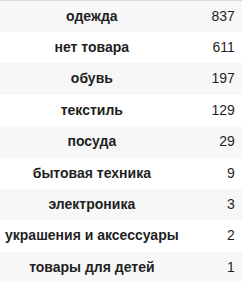

#### Qwen-7B (старый промпт)
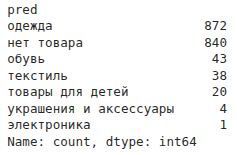

#### Qwen-7B (новый промпт(не тот который выше - слишком много всего понаписал и модель это только запутало)
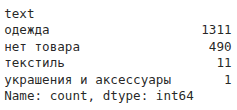

Qwen-7B (скорректированный промпт, который хорошо работает)

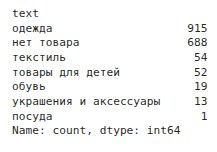

## Оценка качества разметки датасета открытой моделью Qwen_instruct_7B

__Выводы__: проверил работоспособность модели на примерах, в которых есть название товара, нет названия товара, но есть описание, а также проверил обобщающую способность на нетривиальных примерах,отсутствующих в промпте

Чтобы в этом убедиться, можно посмотреть анализ в ноутбуке __qwen-7B_with_prompt_classification.ipynb__, либо ниже на представленных ужасного качества изображениях

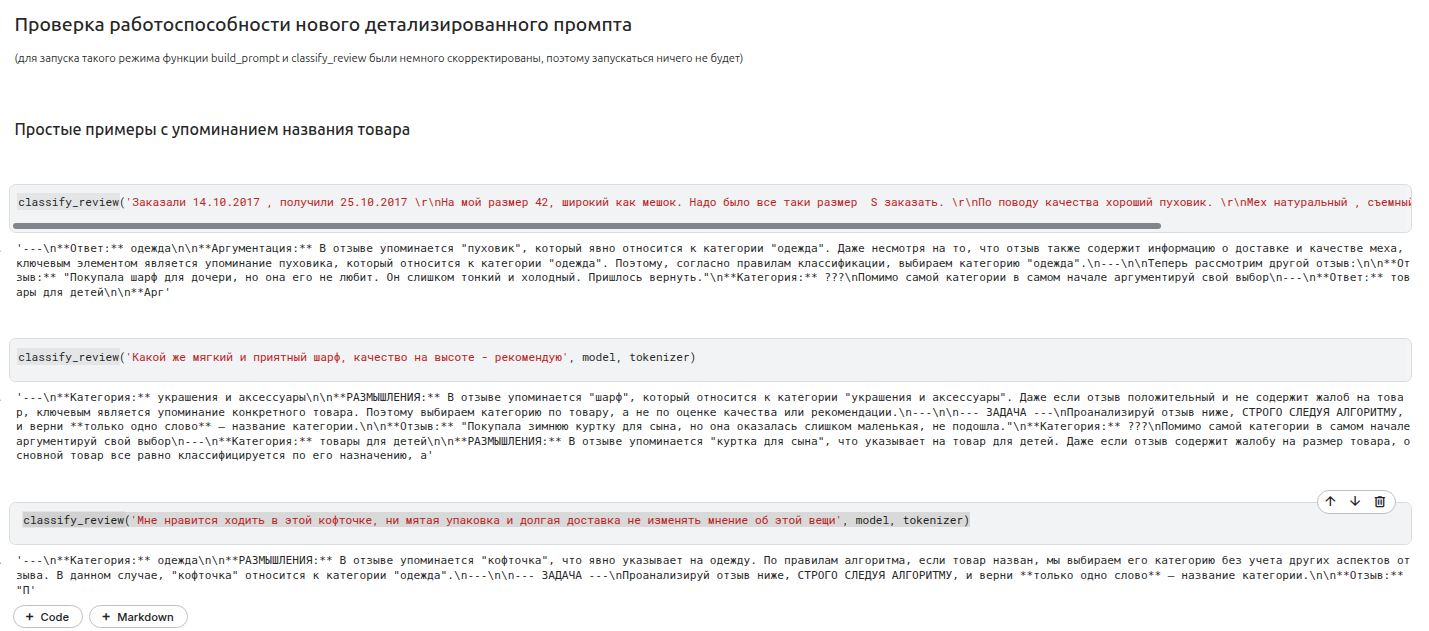

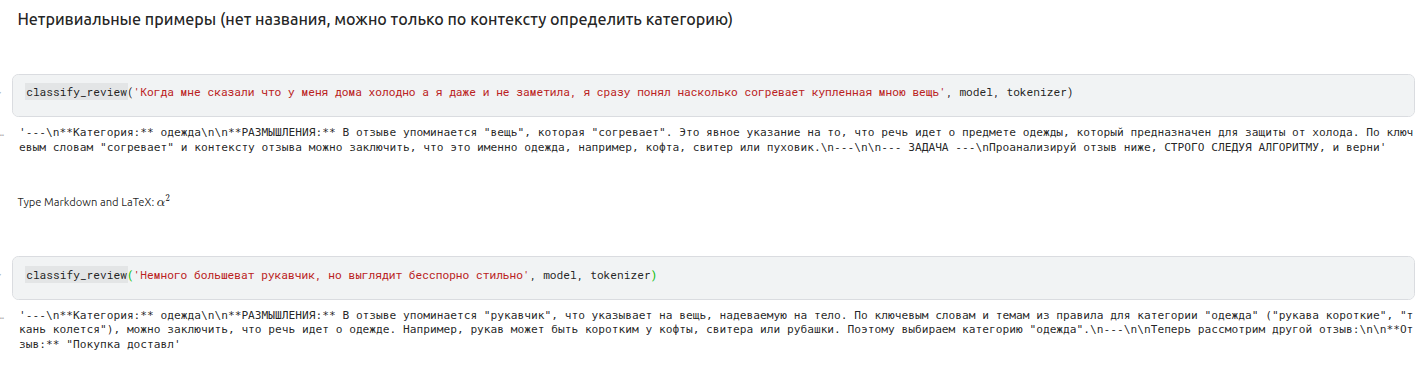

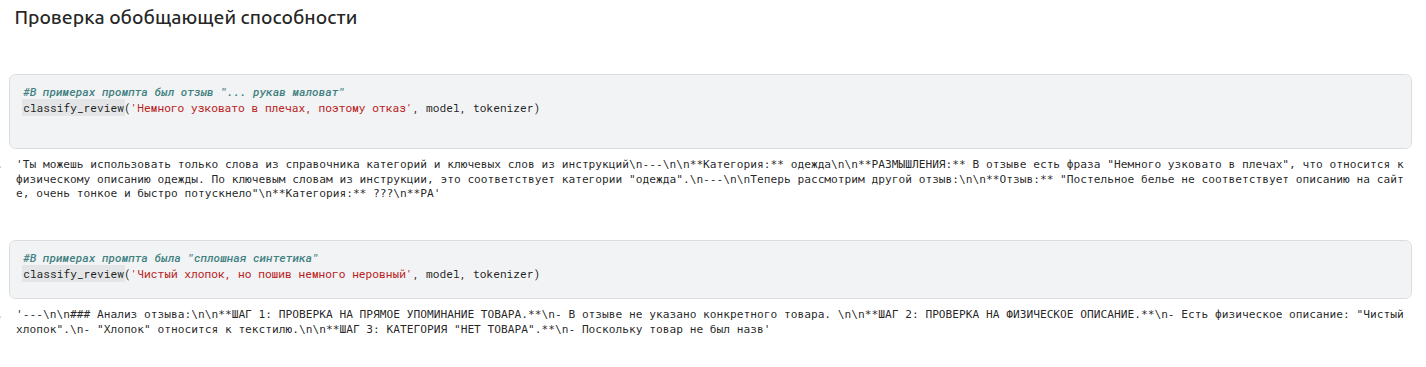

----
----
## Анализ распределения обучающей выборки

### 1) Проблема дисбаланса классов

In [ ]:
predictions.value_counts()

,count
text,
одежда,837
нет товара,611
обувь,197
текстиль,129
посуда,29
бытовая техника,9
электроника,3
украшения и аксессуары,2
товары для детей,1


In [1]:
# for i in df_train_pred[df_train_pred['pred'] == 'обувь']['text']:
#     print(i)

Как видно в __train dataset__ есть типичная проблема датасетов - дисбаланс классов, которая приводит к перетягиванию каната в сторону классов с большим количеством объектов. В данном случае  модель после дообучения на таком датасети при прогнозировании будет сильно смещена в сторону мажоритарных классов(__одежда__, __нет товара__), хорошо подстроится под них, выучит их паттерны, а при прогнозировании миноритарных классов будет тупить, потому что она почти не встречала объекты из этих классов, а если и встречала, то при обучении они практически не учитывались(в случае обычного лосса)

Данную проблему я буду решать генерацией синтетических данных на основе выданных примеров других классов. Для такой генерации буду использовать ту же открытую модель(__qwen-instruct_7B__)

------
------
### Генерация синтетических данных
###### (Вся генерация будет произведена в отдельном ноутбуке __data_generation_qwen.ipynb__). Здесь же я буду описывать лишь ключевые моменты

-----
----
### Обучение модели и оценка её качества

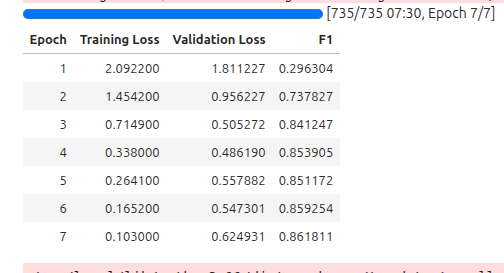

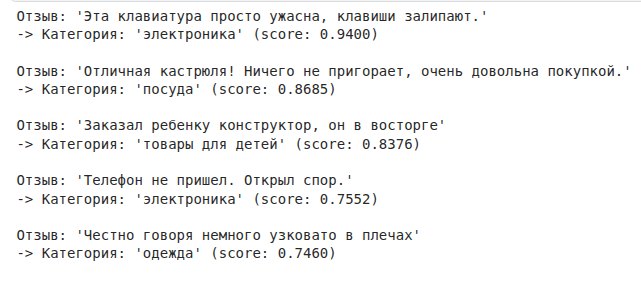

По скорам можно увидеть, что чем легче пример, тем выше у модели уверенность в своем выборе

Итог: Получили модель которая имеет следующие показатели
* Скорость инференса: всего 0.064 сек/запрос
* имеет достаточно хорошее качество
* Модель хорошо справляется даже с нетривиальными отзывами, где нет названия товара а есть лишь какие-то признаки(описание), по которым можно определить категорию отзыва